In [ ]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt


# Data Preparation

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

data_banknote = pd.read_csv(url, header=None)

# Numpy Random Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Extract features and gold labels, reshaping the labels to a column vector
features = data_banknote.iloc[:, :-1].values
labels = data_banknote.iloc[:, -1].values.reshape(-1, 1)

# Initialize StandardScaler
scaler = StandardScaler()

# Normalize features
features_normalized = scaler.fit_transform(features)

# Split features and labels into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

# Neural Network Implementation

In [ ]:
class NeuralNetwork:
    def __init__(self, layers, activation='sigmoid'):
        # Initialize the NN
        self.layers = layers
        self.activation = activation
        self.weights = []
        self.biases = []

        # Randomly initialize weights and biases (except input layer)
        for i in range(1, len(self.layers)):
            self.weights.append(np.random.randn(self.layers[i-1], self.layers[i]))
            self.biases.append(np.random.randn(self.layers[i]))

    #define activation functions
    def activate(self, x):
        if self.activation == 'logistic':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Invalid activation function")

    #forward propagation
    def forward(self, x):
        #lists to store outputs for before and after activation
        self.z = []
        self.a = [x]


        # Iterate through the layers and compute outputs
        for w, b in zip(self.weights, self.biases):
            z = np.dot(x, w) + b
            a = self.activate(z)
            self.z.append(z)
            self.a.append(a)
            x = a
        return x


# PSO Implementation

In [ ]:
class Particle:
    def __init__(self, dimension):
        # Initialize particle, including randomly intializing position, velocity, best informant
        self.position = np.random.randn(dimension)
        self.velocity = np.random.randn(dimension)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')
        self.informants = []
        self.best_informant_position = np.random.randn(dimension)
        self.best_informant_score = float('inf')


class PSO:
    def __init__(self, num_particles, dimension, fitness_function, w=0.7, c1=1.5, c2=1.5, c3=1.5, max_iter=2000, early_stopping_rounds=50):
        # Initialize PSO, random for global best position
        self.particles = [Particle(dimension) for _ in range(num_particles)]
        self.g_best_position = np.random.randn(dimension)
        self.g_best_score = float('inf')
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.max_iter = max_iter
        self.fitness_function = fitness_function
        self.early_stopping_rounds = early_stopping_rounds
        self.initialize_informants_randomly()

    #randomly selecting a number specified number of informants from the particles
    def initialize_informants_randomly(self):
        num_informants = 3
        for particle in self.particles:
            particle.informants = random.sample([p for p in self.particles if p != particle], num_informants)

    def optimize(self):
        # Optimize the swarm using Particle Swarm Optimization
        no_improvement_counter = 0  # Counter for early stopping
        best_fitness = float('inf')

        # Iteratively update particle's position according to its fitness
        for iteration in range(self.max_iter):
            for particle in self.particles:
                fitness = self.fitness_function(particle.position)
                if fitness < particle.best_score:
                    particle.best_score = fitness
                    particle.best_position = particle.position
                # Update global best
                if fitness < self.g_best_score:
                    self.g_best_score = fitness
                    self.g_best_position = particle.position
                    no_improvement_counter = 0
                else:
                    no_improvement_counter += 1

                # Best informant update
                for informant in particle.informants:
                    if informant.best_score < particle.best_informant_score:
                        particle.best_informant_score = informant.best_score
                        particle.best_informant_position = informant.best_position

            # Early Stopping
            if no_improvement_counter >= self.early_stopping_rounds:
                print(f"No improvement for {self.early_stopping_rounds} consecutive iterations. Stopping early.")
                break

            # Update particles
            for particle in self.particles:
                inertia = self.w * particle.velocity
                personal_attraction = self.c1 * np.random.random() * (particle.best_position - particle.position)
                global_attraction = self.c2 * np.random.random() * (self.g_best_position - particle.position)
                informant_attraction = self.c3 * np.random.random() * (particle.best_informant_position - particle.position)

                particle.velocity = inertia + personal_attraction + global_attraction + informant_attraction
                particle.position += particle.velocity

        return self.g_best_position, self.g_best_score

# Fitness evaluator of the particle swarm for NN optimization
class PSOEval:
    def __init__(self, nn, data, labels):
        self.nn = nn
        self.data = data
        self.labels = labels
        # Initialize and calculate total number of parameters in NN
        self.dim = sum([w.size for w in self.nn.weights]) + sum([b.size for b in self.nn.biases])

    # Decodes particle's position vector
    def decode_weights(self, particle_position):
        # Initialize index for particle_position
        idx = 0
        # Update weights
        for i in range(len(self.nn.weights)):
            # Current weight matrix
            rows, cols = self.nn.weights[i].shape
            # Reshape particle_position to match the weight matrix
            self.nn.weights[i] = np.reshape(particle_position[idx:idx + rows * cols], (rows, cols))
            idx += rows * cols
        #Update biases
        for i in range(len(self.nn.biases)):
            length = self.nn.biases[i].size
            self.nn.biases[i] = particle_position[idx:idx + length]
            idx += length

    # Callable method to evaluate the fitness of a particle based on its fitness
    def __call__(self, particle_position):
        self.decode_weights(particle_position)
        predictions = np.array([self.nn.forward(d) for d in self.data])
        # Threshold predictions for binary classification
        binary_predictions = (predictions > 0.5).astype(int)
        # Compute accuracy
        accuracy = np.mean(binary_predictions == self.labels)
        # Lower fitness in PSO so use the complement of the accuracy
        return 1 - accuracy


# Train and Test

In [ ]:
def train_neural_network_with_pso(X_train, y_train, X_test, y_test):
    # Initialize NN with specified layers and activation function
    nn = NeuralNetwork(layers=[X_train.shape[1], 10, 10, 20, 1], activation='tanh')

    # Evaluate the fitness for the training data and NN
    evaluator = PSOEval(nn, X_train, y_train)
    # Calculate total dimension of NN
    dimension = sum([w.size for w in nn.weights]) + sum([b.size for b in nn.biases])

    # Initialize PSO  with specified parameters
    pso = PSO(num_particles=100, dimension=dimension, fitness_function=evaluator)
    pso.optimize()

    # Decode best position found by PSO
    evaluator.decode_weights(pso.g_best_position)

    # Predictions according to the train data
    predictions = np.array([nn.forward(data) for data in X_test])
    # Accuracy of the thresholded predictions
    accuracy = np.mean((predictions > 0.5).astype(int) == y_test)

    return nn, accuracy, pso.g_best_position


def evaluate_neural_network(nn, evaluator, best_weights, X_test, y_test):
    # Decode best weights
    evaluator.decode_weights(best_weights)
    # Prediction for the data in the test set
    predictions = np.array([nn.forward(data) for data in X_test])
    # threhsolded predictions
    binary_predictions = (predictions > 0.5).astype(int)
    # Calculate the accuracy according to true labels
    accuracy = (binary_predictions == y_test).mean() * 100
    return accuracy

In [ ]:
# Get trained neural network and  best weights found during training
trained_nn, accuracy, best_weights = train_neural_network_with_pso(X_train, y_train, X_test, y_test)
evaluator_trained = PSOEval(trained_nn, X_train, y_train)

# Evaluate trained NN on test-set and get the test accuracy
test_accuracy = evaluate_neural_network(trained_nn, evaluator_trained, best_weights, X_test, y_test)
print(f"Test Accuracy: {test_accuracy}%")


No improvement for 50 consecutive iterations. Stopping early.
Test Accuracy: 94.54545454545455%


# Confusion Matrix and ROC Curve

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


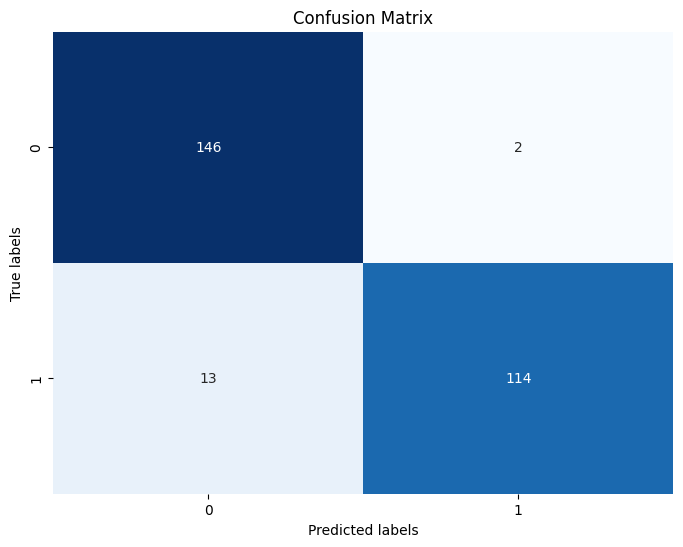

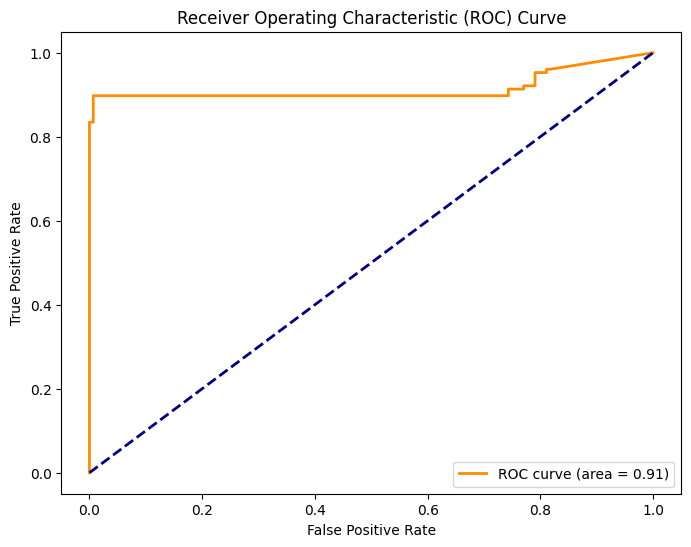

In [ ]:
predictions = np.array([trained_nn.forward(data) for data in X_test])
binary_predictions = (predictions > 0.5).astype(int)

# Plot the confusion matrix
plot_confusion_matrix(y_test, binary_predictions)

# Plot the ROC curve
plot_roc_curve(y_test, predictions)


# Easy way to find Average of 10 experiments

In [ ]:
def run_experiment(X_train, y_train, X_test, y_test, num_particles, w, c1, c2, c3):
    """
    Run a single instance of training the neural network with PSO using specified hyperparameters.

    Parameters:
    X_train, y_train: Training data and labels.
    X_test, y_test: Testing data and labels.
    num_particles: Number of particles in PSO.
    w, c1, c2, c3: PSO hyperparameters for inertia weight, cognitive component, and social components.

    Returns:
    Tuple containing the trained neural network, accuracy on the test set, and the best position found by PSO.
    """

    # Initialize the Neural Network
    nn = NeuralNetwork(layers=[X_train.shape[1], 10, 10, 20, 1], activation='tanh')

    # Initialize the PSOEval with the neural network, training data, and labels
    evaluator = PSOEval(nn, X_train, y_train)

    # Calculate the total number of parameters in the neural network
    dimension = sum([w.size for w in nn.weights]) + sum([b.size for b in nn.biases])

    # Initialize the PSO with the provided hyperparameters
    pso = PSO(num_particles=num_particles, dimension=dimension, fitness_function=evaluator, w=w, c1=c1, c2=c2, c3=c3)

    # Optimize the PSO
    best_position, _ = pso.optimize()

    # Decode the best position found by PSO and evaluate the network on the test set
    evaluator.decode_weights(best_position)
    predictions = np.array([nn.forward(data) for data in X_test])
    accuracy = np.mean((predictions > 0.5).astype(int) == y_test)

    return nn, accuracy, best_position


In [ ]:

# Define your hyperparameters
hyperparameters = [(100, 0.7, 1.5, 1.5, 1.5)]  # Example: num_particles, w, c1, c2, c3

# Store results
experiment_results = {}

for num_particles, w, c1, c2, c3 in hyperparameters:
    key = f"particles_{num_particles}_w_{w}_c1_{c1}_c2_{c2}_c3_{c3}"
    experiment_results[key] = []

    # Run each experiment 10 times
    for i in range(10):
        # Pass all required arguments to the function
        result = run_experiment(X_train, y_train, X_test, y_test, num_particles, w, c1, c2, c3)
        experiment_results[key].append(result)

# Now experiment_results holds all your experiment data


No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.
No improvement for 50 consecutive iterations. Stopping early.


In [ ]:
# Function to print experiment results
def print_experiment_results(experiment_results):
    """
    Prints the results of the experiments, comparing the accuracies across different hyperparameter settings.

    Parameters:
    experiment_results (dict): Dictionary containing the results of the experiments.
    """
    for key, results in experiment_results.items():
        # Extract accuracy values from the results and calculate average
        accuracies = [result[1] for result in results]  # Assuming accuracy is the second element in the tuple
        average_accuracy = sum(accuracies) / len(accuracies)
        print(f"Setting: {key} - Average Accuracy: {average_accuracy:.2f}")

# Call the function to print results
print_experiment_results(experiment_results)


Setting: particles_100_w_0.7_c1_1.5_c2_1.5_c3_1.5 - Average Accuracy: 0.80
